# IMDB Sentiment Analysis with LSTM

In this notebook we want to implement a word-level LSTM network in order to automatically annotate positive and negative IMDB movies reviews.

### Libraries

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
np.random.seed(42)
torch.manual_seed(42)

### Device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Data Pre-Processing and Preparation

Data pre-processing is often a big chunk of every data science, machine learning and deep learning project. Here we want to load IMDB movie reviews and remove very long and very short reviews and encode them in a suitable way for our LSTM network.

### Loading

All the reviews and labels are contained in two separate text files, that can be loaded easily:

In [7]:
reviewsfname = "data/IMDB-Reviews.txt"
labelsfname = "data/IMDB-Labels.txt"

# Load revioews
with open(reviewsfname, "r") as f:
    reviews = f.read()
    
# Load labels
with open(labelsfname, "r") as f:
    labels = f.read()
    
print(f"Reviews:\n{reviews[:1000]}")
print(f"\nLabels:\n{labels[:25]}")

Reviews:
bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audienc

### Cleanup

Reviews can be very messy: they can contain capital letters, lower case letters, all sort of punctiation, etc. In order to make them more uniform we want to remove all punctuation and convert them to lowercase letters:

In [8]:
from string import punctuation

# Look at punctuation
# String containing all puncutation symbols.
print(f"Punctuation: {punctuation}")

# Convert reviews to lowercase
reviews = reviews.lower()
labels = labels.lower()

# Remove punctuation
reviews = "".join([char for char in reviews if char not in punctuation])

Punctuation: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


The cleaned reviews (lowercase, no punctuation) contain only words, therefore in order to get a list of all words we can split the review in all the words:

In [9]:
allwords = reviews.split()

print(allwords[:10])

['bromwell', 'high', 'is', 'a', 'cartoon', 'comedy', 'it', 'ran', 'at', 'the']


Different reviews and labels are separated by newline characters in our dataset. Therefore we can easily split the full text of reviews and labels into a list of reviews and labels:

In [10]:
reviews = reviews.split("\n")
labels = labels.split("\n")

In [11]:
# Check that we have the same number of reviews and labels
assert len(reviews) == len(labels)

print(reviews[:2])
print(labels[:2])

['bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   ', 'story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  viole

### Word Encoding

Words must be encoded in order to be passed to the LSTM network. An easy encoding is to map every unique word to a number. We can start by getting a set of unique words:

In [12]:
words = sorted(set(allwords))
n_words = len(words)

print(f"Number of unique words: {n_words}")
print(f"\n{words[:30]}")

Number of unique words: 74072

['a', 'aa', 'aaa', 'aaaaaaah', 'aaaaah', 'aaaaatch', 'aaaahhhhhhh', 'aaaand', 'aaaarrgh', 'aaah', 'aaargh', 'aaaugh', 'aaawwwwnnn', 'aachen', 'aada', 'aadha', 'aag', 'aage', 'aaghh', 'aah', 'aahhh', 'aaip', 'aaja', 'aakash', 'aaker', 'aakrosh', 'aaliyah', 'aames', 'aamir', 'aan']


Once we have all the words we can map them to an integer. The first word in `words` is mapped to `1`, the second word is mapped to `2` and so on. We start the mapping at `1` because revews have different lengths (different number or words) and therefore we keep the value `0` for padding short reviews to a fixed length.

In [13]:
# Create word to int mapping with 1 as first index
word2int = {word : i for i, word in enumerate(words, 1)}

# Create inverse int to word mapping
int2word = {i : word for word, i in word2int.items()}

# Check conversion
assert len(word2int) == len(int2word)
for word in words:
    assert word == int2word[word2int[word]]

Once we have a mapping between words and integers, we can encode all the reviews:

In [14]:
encodedreviews = []
for review in reviews:
    encodedreviews.append([word2int[word] for word in review.split()])

# Visualize and check encoding
print(f"Reviw 1:\n{reviews[0].split()[:5]}")
print(f"\nEncoded Review 1:\n{encodedreviews[0][:5]}")
print(f"\nEncoding:\n")
for word in reviews[0].split()[:5]:
    print(f"{word:12} => {word2int[word]}")
    
encodedreviews = np.array(encodedreviews)
print(f"\nEncoded Revies Shape: {encodedreviews.shape}")

Reviw 1:
['bromwell', 'high', 'is', 'a', 'cartoon']

Encoded Review 1:
[8210, 29951, 33665, 1, 9819]

Encoding:

bromwell     => 8210
high         => 29951
is           => 33665
a            => 1
cartoon      => 9819

Encoded Revies Shape: (25001,)


### Label Encoding

Reviews are labelles as `negative` or `positive`. This is a binary classification that can be easily encoded by `0` and `1`. Therefore we can easily encode all the labels:

In [15]:
encodedlabels = []
for label in labels:
    encodedlabels.append(0 if label == "negative" else 1)
    
# Visualize and check labels
print(f"Labels:\n{labels[:5]}")
print(f"\nEncoded Labels:\n{encodedlabels[:5]}")

# Transform labels to numpy array
encodedlabels = np.array(encodedlabels)

Labels:
['positive', 'negative', 'positive', 'negative', 'positive']

Encoded Labels:
[1, 0, 1, 0, 1]


### Very Short and Very Long Review

Reviews have very different lengths and therefore there are very short reviews and very long ones. Let's have a look at the review length distribution:

In [16]:
reviewlenghts = [len(review) for review in encodedreviews]

reviewlenghts = np.array(reviewlenghts)

print(f"Minimum Review Length: {np.min(reviewlenghts)}")
print(f"Maximum Review Length: {np.max(reviewlenghts)}")
print(f"Average Review Length: {np.mean(reviewlenghts):.3f}")
print(f"Review Length STD: {np.std(reviewlenghts):.3f}")

Minimum Review Length: 0
Maximum Review Length: 2514
Average Review Length: 240.798
Review Length STD: 179.017


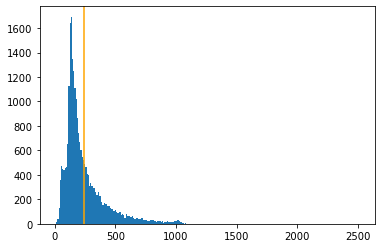

In [17]:
plt.figure()
plt.hist(reviewlenghts, bins=len(reviewlenghts)//100)
plt.axvline(np.mean(reviewlenghts), color="orange", )
plt.show()

We can easily print out the very short reviews:

In [18]:
idxs = np.where(reviewlenghts <= 15)[0]

for idx in idxs:
    print(f"Review {idx}: {reviews[idx]}", end="\n\n")

Review 2137: this movie is terrible but it has some good effects   

Review 4615: ming the merciless does a little bardwork and a movie most foul   

Review 6267: comment this movie is impossible  is terrible  very improbable  bad interpretation e direction  not look       

Review 7959: i wouldn  t rent this one even on dollar rental night   

Review 8709: you  d better choose paul verhoeven  s even if you have watched it   

Review 12816: adrian pasdar is excellent is this film  he makes a fascinating woman   

Review 18873: no comment  stupid movie  acting average or worse    screenplay  no sense at all    skip it   

Review 22219: long  boring  blasphemous  never have i been so glad to see ending credits roll   

Review 25000: 



We see that they make a lot of sense apart from the last one which is empty. Since it's the last one it probably comes from a spurious newline character at the end of the file. We can easily remove all reviews shorter than one word:

In [19]:
encodedreviews = encodedreviews[reviewlenghts > 0] 
encodedlabels = encodedlabels[reviewlenghts > 0]

print(f"Encoded Reviews Shape: {encodedreviews.shape}")
print(f"Encoded Labels Shape: {encodedlabels.shape}")

Encoded Reviews Shape: (25000,)
Encoded Labels Shape: (25000,)


### Truncation and Padding

Long reviews can be problematic since they will slow down the training process. Therefore we decide a maximum review length, `len_sequence` and truncate the long reviews to this length. Something close to the average review length should be enough. Since we want out output to have a fixed size, we also need to pad (with `0`) the shorter sequences.

In [20]:
len_sequence = 256 # Total number of word in a review

paddedreviews = np.zeros((encodedreviews.size, len_sequence), dtype=int)

for i, review in enumerate(encodedreviews):
    paddedreviews[i,-len(review):] = review[:len_sequence]
    
print(paddedreviews)

[[    0     0     0 ... 33768 33726 64394]
 [    0     0     0 ...  5272 57783  8031]
 [30468 46281 30894 ...  7193 41074 46549]
 ...
 [    0     0     0 ... 15007 60837  4144]
 [    0     0     0 ... 46549 71568 25211]
 [    0     0     0 ... 65773 33665 47191]]


### Training, Validation and Test Splits

In order to keep track of the training process and evaluate the final model, we need to split our dataset into three sets: training, validation and test. This can be performed easily with the `train_test_split` function of [Scikit-learn](Scikit-learn). We keep 80% of the original dataset for training, 10% for validation and 10% for test.

In [21]:
# Split 80% of the dataset for training
reviews_train, reviews_vt, labels_train, labels_vt = train_test_split(paddedreviews, encodedlabels, test_size=0.2)
print(f"Reviews Train: {reviews_train.shape}\nLabels Train: {labels_train.shape}")

Reviews Train: (20000, 256)
Labels Train: (20000,)


In [22]:
# Split the reminder 20% for validation and test (50%/50%)
reviews_valid, reviews_test, labels_valid, labels_test = train_test_split(reviews_vt, labels_vt, test_size=0.5)
print(f"Reviews Valid: {reviews_valid.shape}\nLabels Valid: {labels_valid.shape}")
print(f"Reviews Test: {reviews_test.shape}\nLabels Test: {labels_test.shape}")

Reviews Valid: (2500, 256)
Labels Valid: (2500,)
Reviews Test: (2500, 256)
Labels Test: (2500,)


### Data Loaders and Batches

With the dataset split in train, validation and test set we can build a `TensorDataset` (i.e. put together revies and their labels) and the corresponding `DataLoader`. We drop the last batch with `drop_last=True` so that all batches will have the same dimension (for easier debugging).

In [23]:
trainset = TensorDataset(torch.from_numpy(reviews_train), torch.from_numpy(labels_train))
validset = TensorDataset(torch.from_numpy(reviews_valid), torch.from_numpy(labels_valid))
testset = TensorDataset(torch.from_numpy(reviews_test), torch.from_numpy(labels_test))

batch_size = 64

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size, drop_last=True)
validloader = DataLoader(validset, shuffle=True, batch_size=batch_size, drop_last=True)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size, drop_last=True)

We can look at one batch to check that everthing is correct:

In [24]:
trainiter = iter(trainloader)

features, labels = next(trainiter)

print(f"Features Shape: {features.shape}")
print(f"Features:\n{features}")
print(f"Labels Shape: {labels.shape}")
print(f"Labels:\n{labels}")

Features Shape: torch.Size([64, 256])
Features:
tensor([[    0,     0,     0,  ..., 25370, 71489, 33768],
        [31424, 55987,     1,  ...,  7681,  7681, 49515],
        [31424, 26653, 65773,  ...,  2477, 65543, 52123],
        ...,
        [    0,     0,     0,  ..., 10351, 45177, 33768],
        [    0,     0,     0,  ..., 29251, 29037, 63296],
        [61400, 38692, 65543,  ...,  4002, 45809, 65543]])
Labels Shape: torch.Size([64])
Labels:
tensor([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0])


## LSTM Sentiment Analysis

### LSTM Architecture

The LSTM architecture is pretty much standard. We use a `nn.LSTM` module with dropout and a fully connected layer applied to the output. For a character-level RNN the input was one-hot-encoded since the number of different characters is limited. Unfortunately, encoding by words results in a large amount of different words that would be extremely inefficient to one-hot encode. In order to avoid one-hot encoding of several thousands word we can use a `nn.Embedding` (see [Word Embeddings: Encoding Lexical Semantics](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html?highlight=embedding) for more informations). An embedding layer allows to have a  dense encoding of words in a lower-dimensional space (compared to the very sparse one-hot encoding) and also take into account for semantic similarity between words.

In [25]:
class SentimentRNN(nn.Module):
    
    def __init__(self, 
                 n_words, # Number of words 
                 s_embedding, # Embedding size
                 s_hidden, # Hidden layer size
                 n_layers, # Number of LSTM layers
                 dropp=0.5 # Dropout probability
                ):
        
        super().__init__()
        
        n_words += 1 # Add one word for 0 padding
        
        self.s_hidden = s_hidden
        
        # Embedding layer to avoid one-hot-encoding all words
        # Reduce n_words to s_embedding for LSTM input
        self.embedding = nn.Embedding(n_words, s_embedding)
        
        # Define LSTM layer with embedding input
        self.lstm = nn.LSTM(s_embedding, s_hidden, n_layers, dropout=dropp, batch_first=True)
        
        # Define dropout layer between LSTM and FC
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected layer with one output
        # One ouptut for binary classification (positive/negative)
        self.fc = nn.Linear(s_hidden, 1)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        
        # Batch size
        batch_size = x.shape[0]
        
        # Perform word embedding
        x = self.embedding(x)
        
        # Propagate through LSTM
        # Update hidden state
        x, hidden = self.lstm(x, hidden)
        
        # Reshape for FC layer
        x = x.reshape(-1, self.s_hidden)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Fully connecred layer
        # Compress to a single output
        x = self.fc(x)
        
        # Apply sigmoid function
        # Returns values between 0 and 1
        x = self.sigmoid(x)
        
        # Respahe according to batch size
        x = x.reshape(batch_size, -1)
        
        # Get last batch
        x = x[:, -1]
        
        return x, hidden

###  Training

We are now ready for training. We can select hyperparameters for our model, instanciate it and move it to the device:

In [26]:
s_embedding = 500
s_hidden = 256
n_layers = 2

model = SentimentRNN(n_words, s_embedding, s_hidden, n_layers)

model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(74073, 500)
  (lstm): LSTM(500, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


For a binary classification problem (positive/negative review) we can use the binary cross-entropy loss:

In [41]:
lr=0.005

# Binary Cross-Entropy Loss for binary classification
loss_function = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Training and validation are implemended as usual:

In [28]:
epochs = 5
print_every = len(trainloader) // 2

# Training mode
model.train()

steps = 0
for epoch in range(epochs):
    
    # Reset hidden state
    hidden = None
    
    for review, label in trainloader:
        
        steps += 1
        
        # Reset optimizer gradients
        optimizer.zero_grad()
        
        # Move review and label to device
        review, label = review.to(device), label.to(device)
        
        # Forward pass
        output, hidden = model(review, hidden)
        
        # Detach hiddent state from computational graph
        # Avoid backpropagation through the entire history
        hidden = tuple([h.detach() for h in hidden])
        
        # Compute loss
        loss = loss_function(output.squeeze(), label.float())
        
        # Perform backpropagation
        loss.backward()
        
        # Clip gradients norm
        # Prevents the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        # Optimization step
        optimizer.step()
        
        if steps % print_every == 0:
            
            # Evaluation mode
            # Turn off dropout
            model.eval()
            
            with torch.no_grad():
                
                # Reset hidden state for validation
                hidden_v = None
                
                # Validation loss
                loss_v = 0
                
                for rewiev, label in validloader:
                    
                    # Move review and label to device
                    review, label = review.to(device), label.to(device)
                    
                    # Forward pass
                    output, hidden_v = model(review, hidden_v)
                    
                    # Compute validation loss
                    loss_v += loss_function(output.squeeze(), label.float()).item()
                    
            print(f"--- Epoch {epoch}/{epochs}")
            print(f"    Step: {steps}")
            print(f"    Validation Loss: {loss_v/len(validloader):.5f}")
                    
            # Model back to train mode
            model.train()

--- Epoch 0/5
    Step: 156
    Validation Loss: 0.97895
--- Epoch 0/5
    Step: 312
    Validation Loss: 0.99879
--- Epoch 1/5
    Step: 468
    Validation Loss: 1.83703
--- Epoch 1/5
    Step: 624
    Validation Loss: 1.77770
--- Epoch 2/5
    Step: 780
    Validation Loss: 1.75985
--- Epoch 2/5
    Step: 936
    Validation Loss: 1.71410
--- Epoch 3/5
    Step: 1092
    Validation Loss: 2.28626
--- Epoch 3/5
    Step: 1248
    Validation Loss: 2.29612
--- Epoch 4/5
    Step: 1404
    Validation Loss: 2.86544
--- Epoch 4/5
    Step: 1560
    Validation Loss: 2.77071


### Test

After training we are ready to test our model and use it for inference. We can start to put the  model in evaluation mode:

In [29]:
model.eval()

SentimentRNN(
  (embedding): Embedding(74073, 500)
  (lstm): LSTM(500, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Before using the model for inference, we want to look at his perfromance on the test set which is comoposed of previously unseen examples. We can esaily compute the accuracy in addition to the test loss:

In [30]:
# Keep track of test scores and labels
testscores = -np.ones((len(testloader) * batch_size,))
testlabels = -np.ones((len(testloader) * batch_size,))

with torch.no_grad():
    
    # Reset hidden state
    hidden_t = None
    
    # Training loss
    loss_t = 0
    
    # Number of correct predictions
    n_correct = 0
    
    for i, (review, label) in enumerate(testloader):
        
        assert review.shape == (batch_size, len_sequence)
        
        # Move review and label to device
        review, label = review.to(device), label.to(device)
                    
        # Forward pass
        output, hidden_v = model(review, hidden_v)
                    
        # Compute test loss
        loss_t += loss_function(output.squeeze(), label.float()).item()
        
        # Compute test scores and store test labels
        testscores[i*batch_size:(i+1)*batch_size] = output.squeeze().cpu()
        testlabels[i*batch_size:(i+1)*batch_size] = label.squeeze().cpu()
    
        # Compute predictions by rounding scores to 0 or 1
        predictions = torch.round(output.squeeze())
        
        # Compute number of correct predictions
        correct = predictions == label.float().view_as(predictions)
        correct = correct.squeeze().cpu().numpy()
        n_correct += np.sum(correct)
        
print(f"Test Loss: {loss_t / len(testloader):.5f}")
print(f"Accuracy: {n_correct / (len(testloader) * batch_size) * 100:.2f}")

Test Loss: 0.48547
Accuracy: 86.06


For a binary classifier we can easily compute the false positive rate and the true positive rate in order to plot the receiver operating characteristic (ROC) curve. The area under the ROC curve (AUC) is a measure of the classifier performance:

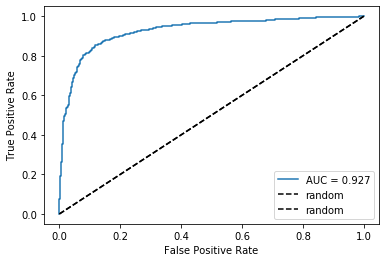

In [42]:
# Get false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(testlabels, testscores)

# Compute area under the ROC curve (AUC)
AUC = roc_auc_score(testlabels, testscores)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {AUC:.3f}")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), "k--", label="random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Inference

In order to perform inference with out trained model we need to transform a review into a pre-processed (and truncated/padded) sequence of encoded word. The can implement all the necessary pre-processing steps in an utility function:

In [43]:
def review_to_tokens(review, len_sequence):
    """
    Transform review (text) to padded sequence of word tokens
    """
    
    from string import punctuation

    # All owercase
    review = review.lower()
    
    # Remove punctuation
    review = "".join([char for char in review if char not in punctuation])
    
    # Split words
    review = np.array(review.split())
    
    # Encode review word by word
    encodedreview = [[word2int[word] for word in review]]
    
    # Truncate or pad review
    paddedreview = np.zeros((1, len_sequence), dtype=int)
    paddedreview[:,-len(review):] = encodedreview[:len_sequence]
    
    # Return review ready for model input
    return paddedreview

We can check that the function behaves as expected:

In [33]:
paddedreview = review_to_tokens("The film was epic!", len_sequence)

assert paddedreview.shape == (1, len_sequence)

print(paddedreview)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0 

For simplicitly, we can also wrap inference in a function that only takes the text to analyze and a model as input and prints the corresponging score:

In [34]:
def analysis(text, model, len_sequence):
    
    model.to(device)
    model.eval()
    
    tokens = review_to_tokens(text, len_sequence)
    
    tokens = torch.from_numpy(tokens).to(device)
    
    hidden = None
    
    output, hidden = model(tokens, hidden)
    
    score = output.squeeze().item()
    
    prediction = np.round(score)
    
    print(f"Score: {score:.2f} | Prediction: {prediction} | {'Positive' if prediction else 'Negative'} Review")

Let's finally use the model on some new review:

In [35]:
analysis("The movie was great!", model, len_sequence)

Score: 0.85 | Prediction: 1.0 | Positive Review


In [36]:
analysis("The movie had some good and bad parts, but I would suggest to watch it!", model, len_sequence)

Score: 0.81 | Prediction: 1.0 | Positive Review


In [37]:
analysis("The movie had some good and bad parts, and I would suggest not to watch it!", model, len_sequence)

Score: 0.05 | Prediction: 0.0 | Negative Review


In [38]:
analysis("I'm not sure how to feel about the movie.", model, len_sequence)

Score: 0.53 | Prediction: 1.0 | Positive Review


In [39]:
analysis("You should never, ever go to watch this movie. It's terrible!", model, len_sequence)

Score: 0.13 | Prediction: 0.0 | Negative Review


In [40]:
analysis("You should never miss this movie!", model, len_sequence)

Score: 0.99 | Prediction: 1.0 | Positive Review
